   # Tracking Macroeconomic Drivers: United States Inflation

   ## Why It Matters

   Understanding inflation dynamics requires systematic analysis of complex, interconnected factors across the economy. Manually tracking inflation drivers across thousands of news reports, economic data releases, and market commentaries is time-consuming and prone to human bias. As inflation remains a critical concern for policymakers, investors, and analysts, there's an urgent need for scalable, systematic approaches to monitor inflation themes.

   ## What It Does

   This workflow is a Macroeconomic Drivers Tracker that breaks down US Inflation into its main components and drivers, then analyzes detailed news reports to extract insights in a structured analytical report. Built for analysts, portfolio managers, and economic researchers, it transforms scattered economic narratives into structured intelligence about inflation dynamics.

   ## How It Works

   The workflow combines **LLM-powered theme taxonomies**, **semantic content retrieval**, and **structured reporting methodologies** to deliver:

   - **Automated theme breakdown** into specific inflation components and drivers
   - **Systematic document analysis** using embeddings-based search and classification
   - **Economic categorization** that turns narrative signals into structured insights
   - **Comprehensive reporting** with analytical summaries for each inflation driver

   ## A Real-World Use Case

   This cookbook demonstrates a complete inflation tracking workflow for **United States Inflation in 2025**, analyzing news coverage from January to February 2025 to identify key inflationary pressures, categorize their economic nature, and generate a professional analytical report.

   ## Setup and Imports

   ## Async Compatibility Setup

   **Run this cell first** - Required for Google Colab, Jupyter Notebooks, and VS Code with Jupyter extension:

   ### Why is this needed?
   Interactive environments (Colab, Jupyter) already have an asyncio event loop running. When bigdata-research-tools makes async API calls (like to OpenAI), you'll get this error without nest_asyncio:

   ```
   RuntimeError: asyncio.run() cannot be called from a running event loop
   ```
   The `nest_asyncio.apply()` command patches this to allow nested event loops.
   💡 **Tip**: If you're unsure which environment you're in, just run the cell below - it won't hurt in any environment!

In [1]:
import datetime
start = datetime.datetime.now()

try:
    import asyncio
    asyncio.get_running_loop()
    import nest_asyncio; nest_asyncio.apply()
    print("✅ nest_asyncio applied")
except (RuntimeError, ImportError):
    print("✅ nest_asyncio not needed or not available")


✅ nest_asyncio applied


   ## Environment Setup



   The following cell configures the necessary path for the analysis

In [2]:
import os
import sys

current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)
print(f"✅ Local environment setup complete")

✅ Local environment setup complete


   ## Import Required Libraries



   Import the core libraries needed for inflation analysis.

In [3]:
import os
from logging import Logger, getLogger
from typing import Dict, List, Optional
import pandas as pd
from pandas import DataFrame, merge
from IPython.display import HTML, display

from bigdata_client import Bigdata
from bigdata_client.models.entities import Company
from bigdata_client.models.search import DocumentType, SortBy

from bigdata_research_tools.labeler.screener_labeler import ScreenerLabeler
from bigdata_research_tools.themes import (
    generate_theme_tree,
    stringify_label_summaries,
)

from src.search import search_by_any
from src.token_manager import TokenManager
from src.summarize import (
    topic_summary,
    summarize_topic_by_theme,
    create_intro_section,
    create_html_report,
    prepare_html_for_display
)
from src.labels import (
    process_request,
    deserialize_responses,
    get_prompts,
    get_topic_drivers_tag_prompt,
    create_label_to_parent_mapping,
    map_risk_category
)
from src.mind_map_tools import (
    get_most_granular_elements
)

from IPython.core.display import HTML

/app/src/summarize.py:294: SyntaxWarning: invalid escape sequence '\$'
  return html.replace("$", "\$")


   ## Define Output Paths



   Define the output paths for inflation analysis results.

In [4]:
# Define output file paths for our results
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

   ## Load Credentials

In [5]:
from dotenv import load_dotenv
from pathlib import Path

script_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
load_dotenv(script_dir / '.env')

BIGDATA_USERNAME = os.getenv('BIGDATA_USERNAME')
BIGDATA_PASSWORD = os.getenv('BIGDATA_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if not all([BIGDATA_USERNAME, BIGDATA_PASSWORD, OPENAI_API_KEY]):
    print("❌ Missing required environment variables")
    raise ValueError("Missing required environment variables. Check your .env file.")
else:
    print("✅ Credentials loaded from .env file")


✅ Credentials loaded from .env file


   ## Connecting to Bigdata



   Create a Bigdata object with your credentials.

In [6]:
bigdata = Bigdata(BIGDATA_USERNAME, BIGDATA_PASSWORD)

BigdataClientAuthFlowError: Sign in process failed, check your credentials.

   ## Defining your Inflation Analysis Parameters



   -  **Main Theme** (``main_theme``): The central concept to explore

   -  **Time Period** (``start_date`` and ``end_date``): The date range over which to run the search

   -  **Document Type** (``document_type``): Specify which documents to search over (transcripts, filings, news)

   -  **Model Selection** (``llm_model``): The LLM model used to mindmap the theme and label the search result chunks

   -  **Rerank Threshold** (``rerank_threshold``): By setting this value, you're enabling the cross-encoder which reranks the results and selects those whose relevance is above the percentile you specify (0.7 being the 70th percentile)

   -  **Focus** (``focus``): Specify a focus within the main theme. This will then be used in building the LLM generated mindmapper

   -  **Source Country** (``source_country``): Specify the country from which the document originates

   -  **Frequency** (``freq``): The frequency of the date ranges to search over. Supported values:

      -  `Y`: Yearly intervals.

      -  `M`: Monthly intervals.

      -  `W`: Weekly intervals.

      -  `D`: Daily intervals. Defaults to `M`.

   -  **Document Limit** (``document_limit``): The maximum number of documents to return per query to Bigdata API.

   -  **Batch Size** (``batch_size``): The number of entities to include in a single batched query.

   -  **Sort By** (``sortby``): Parameter to rank the search results

In [ ]:
# ===== Theme Definition =====
main_theme = "United States Inflation in 2025"

# ===== Focus Definition =====
focus = f"Provide a detailed breakdown of {main_theme} in its main bottom-up components and drivers."

# ===== LLM Specification =====
llm_model = "openai::gpt-4o-mini"

# ===== Document Configuration =====
document_type = DocumentType.NEWS
sortby = SortBy.RELEVANCE

# ===== Enable/Disable Reranker =====
rerank_threshold = None

# ===== Specify Time Range =====
start_date = "2025-01-01"
end_date = "2025-02-28"

# ===== Search Parameters =====
source_country = {'place':['United States']}
freq = "M"
document_limit = 200
batch_size = 100


   ## Mindmap a Theme Taxonomy with Bigdata Research Tools

 You can leverage Bigdata Research Tools to generate a comprehensive theme taxonomy with an LLM, breaking down a theme into smaller, well-defined concepts or sub-themes for more targeted analysis. In this case we are able to extract the drivers

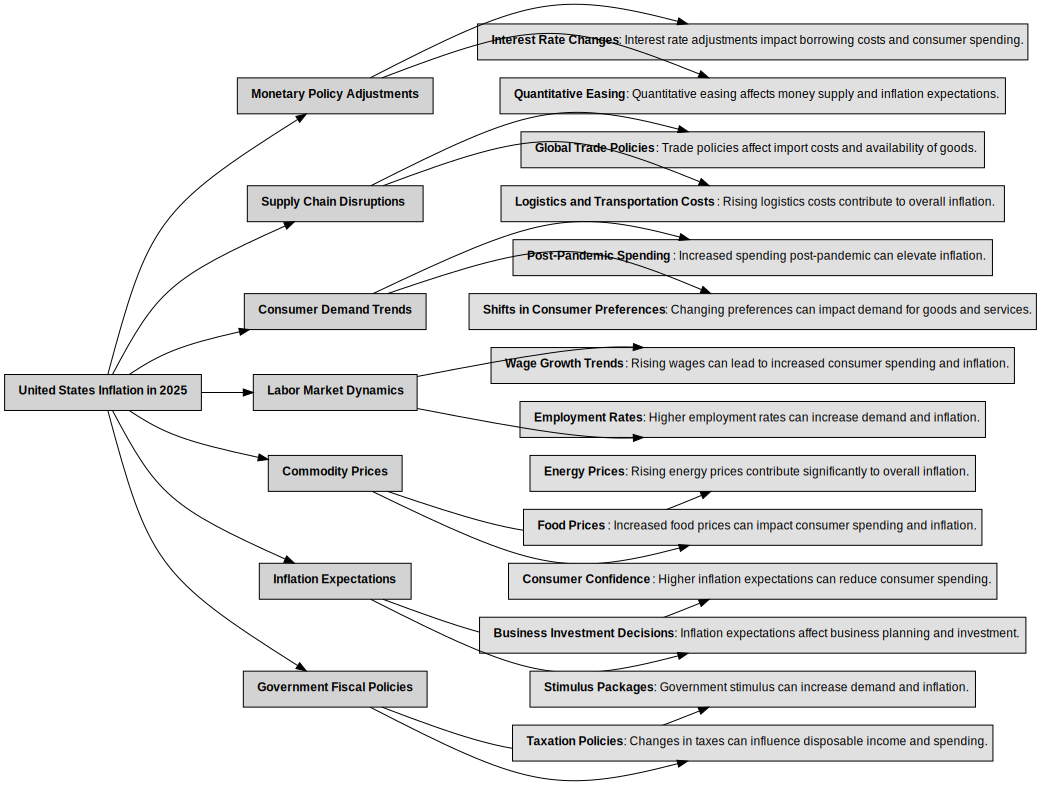

In [8]:
theme_tree = generate_theme_tree(
    main_theme=main_theme,
    focus=focus,
)

sentences_query = theme_tree.get_summaries()
label_to_parent_mapping = theme_tree.get_label_to_parent_mapping()
unique_themes = list(set(label_to_parent_mapping.values()))

theme_tree.visualize()


   ## Retrieve Content using Bigdata's Search Capabilities

 With the theme taxonomy and screening parameters, you can leverage the Bigdata API to run a search across all the news.

In [ ]:
# Use search_by_any for broad company discovery
df_sentences = search_by_any(
    sentences=sentences_query,
    start_date=start_date,
    end_date=end_date,
    scope=document_type,
    companies=None,  # Open discovery - all companies
    control_entities= source_country,
    freq=freq,
    sort_by=sortby,
    rerank_threshold=rerank_threshold,
    document_limit=document_limit,
    batch_size=batch_size,
    bigdata=bigdata
)


Processing news results...: 100%|██████████| 8800/8800 [00:00<00:00, 151384.14it/s]


   ## Label the Results



   Use an LLM to analyze each text chunk and determine its relevance to the inflation sub-themes. Any chunks which aren't explicitly linked to US inflation components will be filtered out.

In [10]:
labeler = ScreenerLabeler(llm_model=llm_model)
df_labels = labeler.get_labels(
    main_theme=main_theme,
    labels=list(theme_tree.get_terminal_label_summaries().keys()),
    texts=df_sentences["masked_text"].tolist(),
)

# Merge and process results
df = merge(df_sentences, df_labels, left_index=True, right_index=True)
df = labeler.post_process_dataframe(df)



Querying OpenAI...:   0%|          | 0/1464 [00:00<?, ?it/s]

Querying OpenAI...: 100%|██████████| 1464/1464 [02:23<00:00, 10.22it/s]


In [11]:
# Filter out 'Not Applicable' results
df_labeled_extracted = df.loc[~(df.Theme.eq('Not Applicable'))].copy()

# Map the labels to the themes
df_labeled_extracted = df_labeled_extracted.rename(columns={'Theme': 'label'})
df_labeled_extracted['theme'] = df_labeled_extracted['label'].map(label_to_parent_mapping)



   ## Text Summarization



   This process concatenates all the text for a given label and instructs an LLM to summarize the text retrieved for each driver. The LLM is specifically instructed to generate an analytical summary that is rich in insights and figures, and excludes events and numbers that are outside of the timeframe of the report.

In [12]:
df_summaries = summarize_topic_by_theme(
    df_labeled_extracted, 
    df_labeled_extracted.theme.unique(),
    df_labeled_extracted.label.unique(), 
    themes_tree_dict= "", 
    api=OPENAI_API_KEY, 
    start_date=start_date, 
    end_date=end_date   
)


In addition, the LLM is instructed to categorize the drivers according to their nature, using specific `drivers_tags` 


In [13]:
drivers_tags = [
    'Demand-pull: When consumer demand exceeds the available supply of goods and services, driving prices up.', 
    'Cost-push: When production costs like labor or raw materials increase, forcing businesses to raise prices.', 
    'Wage increases: Rising wages can contribute to inflation if businesses pass on those costs to consumers in the form of higher prices.', 
    'Global factors: International commodity price fluctuations and exchange rate changes can impact inflation within a country.', 
    'Monetary policy: Central banks actions, like adjusting interest rates, can influence inflation level'
]

tags_prompt = get_topic_drivers_tag_prompt(main_theme, "\n- ".join(drivers_tags))

df_summaries['id'] = range(len(df_summaries))
prompts = get_prompts(df_summaries, columns=['id', 'theme','topic', 'topic_summary'])

responses_tag = process_request(prompts, tags_prompt, api_key=OPENAI_API_KEY)

df_tag = deserialize_responses(responses_tag)

# Concat the original DataFrame with the labels
df_summaries_tag = pd.merge(df_summaries.reset_index(), df_tag.reset_index(),
                      on='index', how='left').drop('index',axis=1)


Completed 13 requests in 12.23 seconds.


   ## Generate the Report



   As a final step, an LLM uses the last dataframe to generate a brief introduction for the report, summarizing the contents in a few sentences.



   The report is then formatted and composed by organizing it by the key driver labels defined above and rendering it in HTML format.

In [14]:
# Create HTML report
intro_section = create_intro_section(df_summaries_tag, OPENAI_API_KEY, main_theme)
html_report = create_html_report(main_theme, start_date, end_date, intro_section, df_summaries_tag)
display(HTML(prepare_html_for_display(html_report)))

In [15]:
# Save HTML report to file
html_report_path = f'{output_dir}/United_States_Inflation_Report_2025.html'
with open(html_report_path, 'w') as file:
    file.write(html_report)
print(f"✅ HTML report saved to {html_report_path}")

✅ HTML report saved to output/United_States_Inflation_Report_2025.html


In [16]:
# Export data to Excel
try:
    # Create the Excel manager
    excel_manager = ExcelManager()

    # Define the dataframes and their sheet configurations
    df_args = [
        (df_labeled_extracted, "Labeled Inflation Data", (0, 0)),
        (df_summaries, "Topic Summaries", (2, 4)),
        (df_summaries_tag, "Final Tagged Report", (2, 2))
    ]

    # Save the workbook
    excel_report_path = f'{output_dir}/inflation_analysis_results.xlsx'
    excel_manager.save_workbook(df_args, excel_report_path)
    print(f"✅ Excel results exported to {excel_report_path}")

except Exception as e:
    print(f"Warning while exporting to excel: {e}")

Warning while exporting to excel: name 'ExcelManager' is not defined


In [17]:
print("Runtime:", datetime.datetime.now() - start) 

Runtime: 0:05:31.815932
